# Optimization, Optax and Haiku



<a href="https://colab.research.google.com/github/khipu-ai/practicals-2023/blob/main/notebooks/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright

* Deep Learning Indaba 2022. Apache License 2.0.
* Khipu 2023. Apache License 2.0.

## Authors

* Kale-ab Tessera (Indaba 2022)
* Ignacio Ramírez (Khipu 2023)

## Reviewers
* Javier Antoran
* James Allingham
* Ruan van der Merwe
* Sebastian Bodenstein
* Laurence Midgley
* Joao Guilherme
* Elan van Biljon


# Introduction

The three topics introduced in this practical aim at providing you with the tools to train your models. We will begin with the basic concepts of **numerical optimization**, in particular cost function minimization, which is the main method whereby we learn models.

We will then show you how to use the [Optax](https://github.com/deepmind/optax) library, an efficient optimization library based on JAX.

Finally, we'll visit [Haiku](https://github.com/deepmind/dm-haiku), a library for building and training neural networks.

## Prerequisites

We will assume that you are familiar with Python, Numpy and JAX. If not, please check out our [Practical](http://no.link.yet).

## Requirements

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.



## Installation and Imports

In [75]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

import os

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")
    # x8 cpu devices - number of (emulated) host devices
    os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

import matplotlib.pyplot as plt
import numpy as np

a GPU is connected.


In [76]:
# @title Helper Functions. (Run Cell)
import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )

In [77]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 1
 Devices: [GpuDevice(id=0, process_index=0)]


$$
\newcommand{\because}[1]{&& \triangleright \textrm{#1}}
$$

# Model learning and optimization

Machine learning is all about learning _models_. In this context, models are mathematical objects that synthesize our knowledge on data from some domain. This knowledge then allows us, for example, to infer the output or response of a system given a certain input (regression, classification), to synthesize new data samples (unsupervised learning, simmulations, generative models), or to take the optimal action in a certain context (reinforcement learning).

In any case, models are defined by a certain functional form which depends on a set of _parameters_ $\theta$ (this includes _non parametric_ models despite the name). Although the general form of a model may be known beforehand (e.g., a certain neural network architecture), its parameters are not, and depend on the data that we want to process.

The process of adjusting (learning) the parameters of a model is usually done by defining a  _cost function_ which tells us how good our model is for some data, and then tuning the parameters $\theta$, automatically, to minimize the cost; this is done by means of _optimization algorithms_.

## Linear regression

$\def\reals{\mathbb{R}}$
$\def\tr{^\mathsf{T}}$
$\def\data{\mathcal{D}}$
$\def\opt{^{*}}$
$\def\loss{\ell}$
$\newcommand{\mat}[1]{\mathbf{#1}}$
$\newcommand{\vec}[1]{\mathbf{#1}}$
$\def\inv{^{-1}}$
A simple example to begin with is linear regression. Given an input vector $x\in\reals^m$ and an output $y\in\reals$, we assume that the input-output relationship is $y=w\tr x + b$ where $\theta=(w,b),w \in\reals^m, b \in \reals$  are parameters to be tuned.

For the this practical we will assume that $b=0$ so that $\theta=w$. It is easy to generalize to the case $b \neq 0$.

The following code generates data approximately following the above relation.




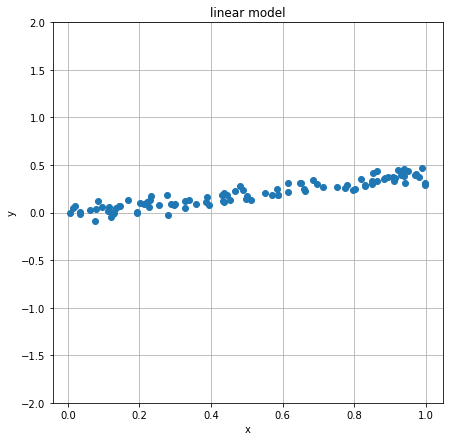

In [78]:
from numpy import random

rng = random.default_rng(2023)

def sim_linear_model(weights, num_samples, noise_std=0.05):
  """
  given a linear coefficient w and a non-negative integer n
  generate n samples according to y = wx + b + v
  where v is a random Gaussian variable with mean 0
  and standard deviation 0.1
  """
  sample_dim = len(weights)
  X = random.uniform(size=(sample_dim,num_samples))
  noise = noise_std*random.normal(size=num_samples)
  y = weights @ X + noise
  return X,y

#
# our ground truth, w = 0.4
#
w = [0.4]
#
# simmulate samples
#
x,y = sim_linear_model(w, 100)
#
# plot simmulated data
#
plt.figure(figsize=(7,7))
plt.plot(x.T,y,'o') # plot expects x to be a column
plt.title('linear model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.ylim(-2,2)
plt.show()

In general, we don't know $w$; what we have instead is data given as pairs $\data = \{(x_i,y_i):i=1,\ldots,n\}$ for which we assume that the above functional relationship holds, at least approximately. 

What we need to do is to find optimal values of $w\opt$ so that the relationship $y=w\tr x$ holds as best as possible, that is, we want $y-w\tr x \approx 0$ for every data pair. A natural way of doing so is to compute the accumulated squared approximation error $(y-w\tr x)^2$ for all the samples in the data. With this, we can now define our loss function $\ell(\data;w)$:

$$\ell(\data;w) = \frac{1}{n}\sum_i^n (y_i - w\tr x_i)^2$$

where $1/n$ is just a normalization constant. For simplicity, we will drop the $\data$ and write $\loss(x)$ hereafter. However, remember that this is a function of $\data$ as well.  In the one-dimensional case above, we can actually plot $\loss(w)$. Let's try this for a range of values:



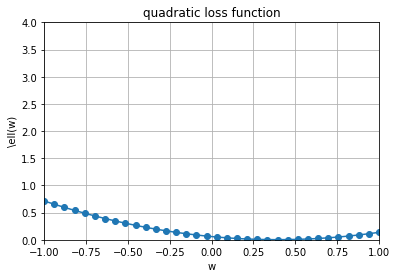

In [79]:
def quadratic_loss(x,y,w):
  """ 
  quadratic loss function
  """
  return np.mean( (w @ x - y)**2 ) # we divide by n to keep things small
#
# 100 parameter values between -3 and 3
#
# tech detail: the 'reshape' trick here turns the returned vector
# ws (which has 1 dimension) into a 1x100 matrix (with _two_ dimensions)
# so that each element ws[i] is also treated as a 1x1 matrix and not a scalar
#
ws = np.linspace(-3,3,100).reshape(-1,1) 
#
# very nice Python stuff: comprehensions
#
ls = [quadratic_loss(x,y,w.T) for w in ws]


plt.figure(figsize=(6,4))
plt.plot(ws,ls,'o-')
plt.title('quadratic loss function')
plt.xlabel('w')
plt.ylabel('\ell(w)')
plt.ylim(0,4)
plt.xlim(-1,1)
plt.grid(True)
plt.show()

So we see above that the function is a simple parabola. In $n$-dimensional problems, it is actually, always, a paraboloid. 

## Finding the optimal parameters

So how do we find $w\opt$? Well, as we can see, and as any paraboloid, $\loss(w)$ it is a convex function of $w$, which means that it there exists a parameters $w\opt$ so that the loss is minimal with respect to any other parameter values. In this case the function is strongly convex, which means that $w\opt$ is unique. 

Basic calculus tells us that, when a minima is attained, the derivative of $\ell(w)$ is $0$. For this case, we can find the optimal parameters right away by differentiating and solving for $w$:

$$\frac{d\ell}{dw}=\frac{2}{n} \sum_i (y_i - w\tr x_i)x_i = 0\;\Rightarrow\sum_i y_ix_i\tr  - \sum_i \tr x_ix_i\tr w = 0$$

When we work with Machine Learning, and in optimization in general, it is convenient to express such relationships in a more compact way. This makes it more clear and, fundamentally, allows us to speed up computations. In our case, if we define $\mat{X}\in\reals{m{\times}n}$ to be a matrix whose columns are $x_i$, and $\vec{y}$ a vector whose elements are $y_i$, we can write the above relationship as:

$$\frac{\partial \loss(w)}{\partial w} = \mat{X}\vec{y} - \mat{X}\mat{X}\tr w = 0 \Rightarrow \mat{X}\vec{y} = \mat{X}\mat{X}\tr w.$$

We can now premultiply both sides by $(\mat{X}\mat{X}\tr)\inv$ to obtain $w\opt$ (provided that the inverse exists):

$$w\opt = (\mat{X}\mat{X}\tr)\inv\mat{X}\vec{y}.$$

The above is known as the _least squares_ solution to the quadratic cost regression problem. Let's compute it:





In [80]:
w_ls =  np.sum(x @ y)/np.dot(x,x.T)
print('true w:',w,'w found by least squares:',w_ls)

true w: [0.4] w found by least squares: [[0.39348503]]


### Comments

Notice that the  parameter _estimated_ by least squares is not the exact, true value $0.4$. Why might this be? 

In any case, it is quite close. 

## Gradient descent

So why bother with optimization algorithms? There are two main reasons:

1. The parameters $w\opt$ cannot be found by hand. **this happens most of the time**
1. In some cases, although the a closed form solution exists, it may be very hard to compute. Imagine for example that the dimension of the data samples is $n=1000000$; this might be a small $1000{\times}1000$ image. In most computers we will have a hard time inverting a $1000000{\times}1000000$ matrix!

When any of those occur, we need to find the solution in a different way. Optimization algorithms do so _iteratively_. 

There are brute force algorithms which try to find the solution by evaluating the cost function for many values of $w$, but this is impractical unless $n$ is very small, for example $1$. Sometimes, this is all you can do. However, if the cost function to be minimized is _differentiable_, there is a smarter way to look for solutions by following the _gradient_ of the function, but in the opposite direction.

The rationale behind this idea is simple: by definition, the gradient of the const function, $\nabla \loss(w)$, indicates  the direction along which the function _increases the most_. Thus, if we go the opposite direction, we can expect the function to _decrease the most_. Algorithms based on this idea are known as _descent methods_. Those that go in the exact opposite direction, $-\nabla \loss(w)$, are known as _gradient descent methods_.

Linear models with quadratic losses are excellent examples to begin exploring descent techniques because we can find the exact solution by hand and thus monitor our progress. We will now step up the problem a bit and work in two dimensions.

 

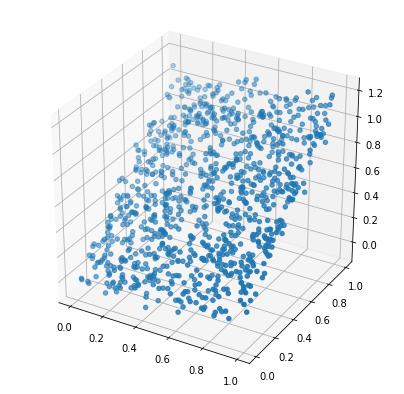

ground truth: [0.1, 1.0] 
least squares solution: [0.10186632 1.00267254]


In [81]:
# 3D plotting stuff
from mpl_toolkits.mplot3d import axes3d
from numpy import linalg as la
#
# our ground truth, w = [0.1,1.0]
#
w = [0.1,1.0]
#
# simmulate samples, now in 3D
#
X,y = sim_linear_model(w,1000,noise_std=0.05)
#
# plot simmulated data
#
fig = plt.figure(figsize=(7,7))
ax3 = fig.gca(projection='3d')
ax3.scatter(X[0,:],X[1,:],y) # plot expects x to be a column
plt.grid(True)
plt.show()
#
# least squares solution
# can also be obtained using linalg's lstsq function, btw
#
w_ls = (la.inv(X @ X.T)) @ (X @ y)
print('ground truth:',w,'\nleast squares solution:',w_ls)


## The gradient descent algorithm

$\newcommand{\iter}[1]{^{(#1)}}$
The gradient descent algorithm is quite straightforward:

1. choose some initial solution (may be anything, e.g. $\theta\iter{0}=0$)
2. compute the gradient at the current solution $\theta\iter{t}$, $\nabla \loss(\theta\iter{t})$
3. update the solution: $\theta\iter{t+1} \leftarrow \theta\iter{t} - \eta\nabla \loss(\theta\iter{t})$
4. repeat steps 2-3 until some stopping criterion is met (e.g., $\|\nabla\loss(\theta\iter{t})\|_2 < \epsilon$, a maximum number of iterations $T$ is reached, etc.)

We can implement this method in a rather general form by passing the gradient computation function as a parameter:

In [82]:
def train_model_manual(theta_0,fun,grad,stepsize=1e-2,tolerance=1e-4,maxiter=1000):
  """
  gradient descent function
  :param w_0: initial solution
  :param fun: cost function 
  :param grad: gradient of the cost function
  """
  weights = list()
  costs   = list()
  grad_norms = list()
  theta_t = theta_0
  for t in range(maxiter):
    #
    # values at current iteration
    #
    g_t = grad(theta_t)
    f_t = fun(theta_t)
    n_t = la.norm(g_t)
    #
    # check for stopping condition
    #
    if n_t < tolerance:
      break
    #
    # store current solution
    #
    weights.append(theta_t)
    costs.append(f_t)
    grad_norms.append(n_t)
    #
    # update solution
    #
    theta_t = theta_t - stepsize*g_t

  return weights,costs,grad_norms



## Computing the gradient

The last ingredient we need is of course the gradient. 
We already saw that:

$$\frac{\partial \loss(w)}{\partial w} = \frac{2}{n}\mat{X}(\vec{y} - \mat{X}\tr w)$$



In [83]:
def loss_fun(_X,_y,_theta):
  _w = _theta
  _e = _w.T @ _X - _y
  return np.mean(_e**2)


def loss_grad_manual(_X,_y,_theta):
  _w = _theta
  _e = _w.T @ _X - _y
  _n = len(_y)
  return (2/_n)*(_X @ _e.T)


**Exercise**
1. Run the cell  below for different choices of `eta` and `w_0`, and note the trajectory of $(w,b)$
1. Can you find a setting for $\color{blue}{\eta}$ where things start spiraling out of control and the loss gets bigger and bigger (and not smaller)?
1. Can you find a setting for $\color{blue}{\eta}$ so that we're still far away from the minimum after `200` parameter update steps?



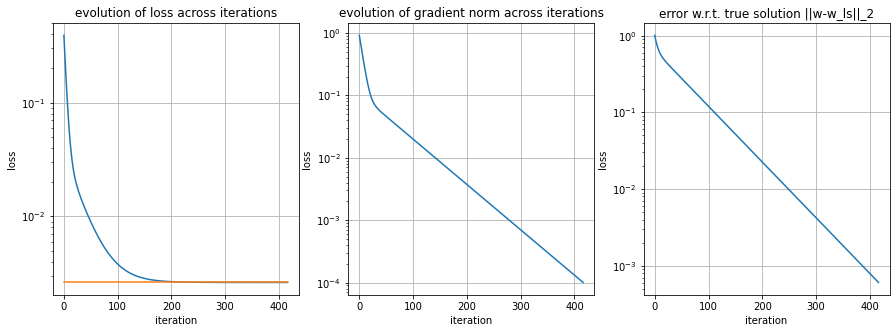

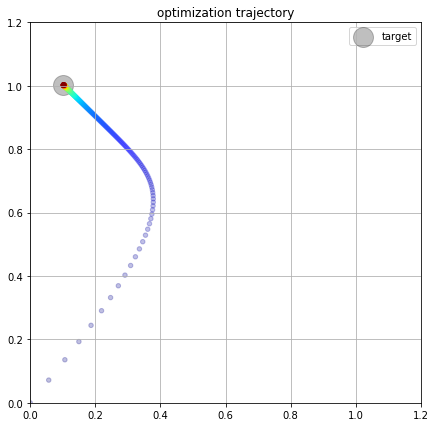

In [84]:
eta = 0.1  # Change me! Try 0.1, 0.5, ...
w_0 = np.zeros((2,1))
#
# we wrap loss_fun and loss_grad so that they are only a function of w
#
f = lambda w: loss_fun(X,y,w)
g_man = lambda w: loss_grad_manual(X,y,w)
#
# call the algorithm
#
weights,costs,norms = train_model_manual(w_0,f,g_man,stepsize=eta)

#
# show it
#
def plot_optimization(weights,costs,norms):
  """
  helper function for plotting our thing
  """
  niter = len(costs)
  loss_ls = loss_fun(X,y,w_ls)            

  plt.figure(figsize=(15,5))

  plt.subplot(1,3,1)
  plt.semilogy(costs)
  plt.semilogy([0,niter],[loss_ls,loss_ls])
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('evolution of loss across iterations')
  plt.grid(True)

  plt.subplot(1,3,2)
  plt.semilogy(norms)
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('evolution of gradient norm across iterations')
  plt.grid(True)

  errors = [la.norm(w.ravel()-w_ls.ravel()) for w in weights]
  plt.subplot(1,3,3)
  plt.semilogy(errors)
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('error w.r.t. true solution ||w-w_ls||_2')
  plt.grid(True)
  #
  # show trajectory with some fancy coloring
  #
  from matplotlib import cm 
  colors = cm.jet(np.arange(niter)/niter)
  plt.figure(figsize=(7,7))
  wmat = np.array(weights)
  plt.scatter(w_ls[0],w_ls[1],color='black',alpha=0.25,s=400,label='target')
  plt.scatter(wmat[:,0],wmat[:,1],s=20,c=colors,alpha=0.25)
  plt.xlim(0,1.2)
  plt.ylim(0,1.2)
  plt.grid(True)
  plt.title('optimization trajectory')
  plt.legend()
  plt.show()

#
# call it
#
plot_optimization(weights,costs,norms)


## Automatic differentiation with JAX

In many applications, notably in Deep Learning, the cost function gradient is quite complicated. In any case, doing so by hand is prone to errors, and thus best avoided.

Automatic differentiation (usually known as _autograd_) is a technique whereby the gradient of a function defined by the user is computed exactly by parsing the function and applying the standard rules for differentiation: chain rule, linearity, etc.  

Autograd is a main feature of DL libraries such as PyTorch and Tensorflow which enables one to create new architectures while avoiding complicated calculations in each case. However, in those applications, autograd is tightly integrated into the libraries themselves. 

One of the main features of JAX is an "application agnostic"  autograd feature which one can use on any function, provided that it follows the functional programming rules required by all JAX functions (check out the JAX tutorial on this). In JAX, the gradient of a function is a type of _transformation_, that is, it takes a function and returns another one. In the case of _autograd_, the transformation is called `grad` and is called as follows:

```
loss_grad = jax.grad(loss_fun, argnums=(2))
```

Here `argnums` tells JAX that we want the partial derivative of our function with respect to the second parameter, which is $w$. 

Note that we need to redefine `loss_fun` so that it uses JAX operations instead of NumPy.

In [85]:
def loss_fun_jax(X, y, w):
  """
  JAX-based implementation of mean squared loss
  """
  errors = jnp.square(y - w.T @ X)
  return jnp.mean(errors)

f_jax = lambda w: loss_fun_jax(X,y,w)
# 
# after this, the returned value  g_auto is a function 
# that computes the gradient of f_jax with respect to w
# 
g_jax = jax.grad(f_jax, argnums=(0))

#x = np.array(x_data_list)
#y = np.array(y_data_list)


#
# let's see if it works... should give the same result
#
w = np.array([0.,0.])
g_w_jax = g_jax(w)
print("Automatic gradient: ", g_w_jax)

g_w_manual = g_man(w)
print("Manual gradient:", g_w_manual)

print("Difference:", g_w_manual-g_w_jax)

# 
# check that the results are close
# they are not exactly the same, as the rounding may be different depending
# on the hardware implementation
#
assert jnp.isclose(g_w_jax[0],g_w_manual[0]) and jnp.isclose(g_w_jax[1],g_w_manual[1])


Automatic gradient:  [-0.56966853 -0.71630156]
Manual gradient: [-0.56966849 -0.7163015 ]
Difference: [5.9604645e-08 5.9604645e-08]


Nice! So we can use automatic differentiation and we don't have to manually calculate gradients. 

# Optimization using Optax

We've seen how to apply Gradient Descent to a simple linear model. The idea is really simple and, conceptually, doesn't go much deeper than that. However, manually implementing this method (or others) for each model that we want to try is really tedious, complicated, and error-prone.

This is where optimization libraries come to the rescue. For JAX we have 
[Optax](https://github.com/deepmind/optax), which leverages from the capabilities of JAX, in particular automatic differentiation, to run optimization methods such as vanilla gradient descent, or more advanced ones such as ADAM, on any loss function we may have. Let's see this applied to our problem, and compare it to our previous solution.


In [86]:
%%capture
# @title Install Optax. (Run Cell)
!pip install -U optax


Below we re-implement our optimization algorithm using Optax. The code here is almost identical to the previous one, with two important differences:

1. **The direction $d_t$ where we will move our current solution to (the _update_) is now given by the _optimizer_.** Advanced optimizers such as ADAM utilize not only the current gradient but also past gradients to define the updates so that the overall method works better for more challenging loss functions, for example, with multiple local minima.
1. **The parameters `theta` and the gradients need to be specified as _dictionaries_.** This is because large models are usually organized in groups of parameters, for example, the weights of different layers of a deep neural net. In our case we have a single parameter $\theta=w$, but still we need b

In [87]:
import optax
import jax.numpy.linalg as jla

def train_model_optax(theta_0,fun,grad,stepsize=1e-2,tolerance=1e-4,maxiter=1000):
  """
  optimization using Optax
  :param w_0: initial solution
  :param fun: cost function 
  :param grad: gradient of the cost function
  """
  #
  # create optimizer
  # this guy defines how to update the parameters in each iteration
  #
  optimizer = optax.sgd(stepsize) # TRY other optimizers and stepsizes!! optax.adam
  #
  # initial parameters
  #
  # Optax expects a dictionary parameters
  # in this case we have only one: w
  #
  theta_t = {"w": jnp.copy(theta_0)}
  #
  # all Optax optimizers have an inner state that needs to 
  # be stored and updated between calls
  #
  state_t = optimizer.init(theta_t)
  
  weights = list()
  costs   = list()
  grad_norms = list()
  #
  # main optimization loop
  #
  for t in range(maxiter):
    #
    # values at current iteration
    #
    w_t = theta_t["w"]
    g_t = grad(w_t)
    f_t = fun(w_t)
    n_t = jla.norm(g_t)
    #
    # check for stopping condition
    #
    if n_t < tolerance:
      break
    #
    # store current solution
    #
    weights.append(w_t)
    costs.append(f_t)
    grad_norms.append(n_t)
    #
    # update solution (here comes Optax)
    #
    # Optax expects a dictionary of gradients, one per parameter
    # corresponding to the dictionary of parameters above
    #
    g_t = {"w":g_t} 
    d_t, state_t = optimizer.update(g_t, state_t)
    theta_t = optax.apply_updates(theta_t, d_t)

  return weights,costs,grad_norms


    

### Running our optax-powered optimizer

Run the cell below to see our latest method in action.

<hr>

**ExcerciseL** try again, now changing the optimizer and/or the stepsize (see [Common Optimizers](https://optax.readthedocs.io/en/latest/api.html) ). One popular one is ADAM (`optax.adam`)


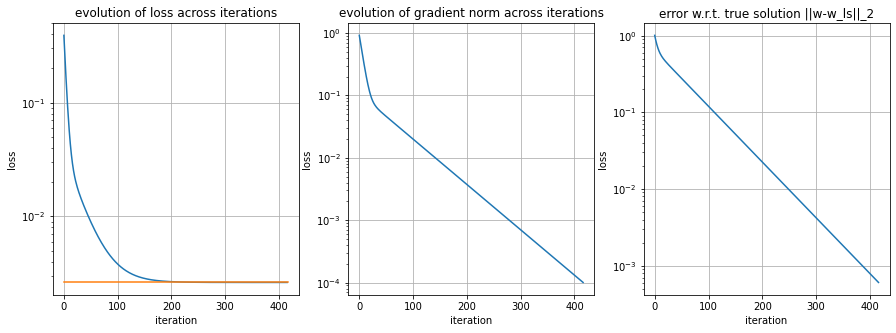

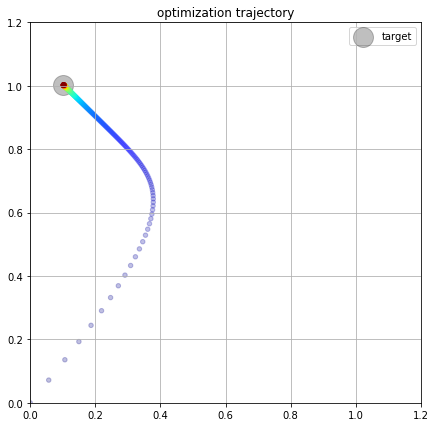

In [88]:
#
# initialization
#
w_0 = jnp.zeros((2,1))
#
# call the algorithm
#
weights,costs,norms = train_model_optax(w_0,f_jax,g_jax,stepsize=0.1)

plot_optimization(weights,costs,norms)

# Training Models with Haiku

So far we've seen how to use JAX and Optax to implement an optimization loop.
Thanks to these two libraries, we can exploit our computing resources to the maximum, forget about computing gradients by hand, and to define the descent direction altogether.

What if we now want to build a deep neural model? If we want to do it with JAX, we need JAX-enabled blocks (dense, convolutional, relus, maxpool, etc.) and a way to construct and maintain the state of the resulting mammoth.

Here's where [Haiku](https://github.com/deepmind/dm-haiku) comes in, by providing a JAX-based alternative to those familiar with  the traditional Pytorch or Tensorflow libraries.

## Haiku is object oriented

Haiku is an *object-oriented* library, meaning that our models, their parameters, etc., are represented as _instances_ of _object classes_. If you are not familiar with object oriented programming, you should learn this concept first. There are many tutorials on the subject ([example](https://realpython.com/python3-object-oriented-programming/)).

## JAX is functional oriented

However, there is a twist, as JAX follows the  _functional programming_ paradigm! 

Haiku modules are similar to standard python objects (they have references to their own parameters and functions). However, since JAX operates on *pure functions*, Haiku modules **cannot be directly instantiated**, but rather they need to be **wrapped into pure function transformations.**

So, the overall rationale is to:

* write an object for your model
* wrap the object so that it is seen by JAX as a set of pure functions

Don't worry. It sounds more complicated than it is.

In [89]:
%%capture
#@title Run this cell to install Haiku!
!pip install -U dm-haiku


## Wrapping a model in Haiku

We'll now create a linear model in the way of Haiku. This linear model contains another parameter `b`, a constant (bias) term that is added to the linear combination, so that $y=wx+b$.

The core object in Haiku is a `Module`. A module contains parameters and a function `__call__` that combines these parameters and user input to produce an output. This is what we could call a `block` within a Neural Network.



In [90]:
import haiku as hk

class MyLinearModel(hk.Module): # notice: model inherits from haiku.Module
  """
  Haiku-based linear model of the form y=w*x+b

  A Haiku module is expected to implement __call__ in order to produce
  its output.
  """
  
  def __init__(self, output_dim, name=None):
    """
    :param output_dim: dimension of the model output (y)
    """
    super().__init__(name=name)
    self.output_dim = output_dim


  def __call__(self, x):
    """
    special function, gets called when we use the () operator on an instance
    """
    j, k = x.shape[-1], self.output_dim
    #
    # note: the three lines below are actually called *once* and serve
    # to declare and initialize the parameters of the model.
    # 
    w_init = hk.initializers.TruncatedNormal(1.0 / np.sqrt(j))
    w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
    b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
    #
    # this is the actual code that's executed when the module is called
    #
    return jnp.dot(x, w) + b

### Wrapping the Module

In order for a module to be used by JAX, it needs to be treated not as an object, but as a set of pure functions plus a _state_, which has to be explicitly fed to the functions.

The wrapping is done by the Haiku `transform` function. This wrapper takes a **function** of one or more Haiku Modules (not just any class) and "eviscerates" the modules it to bring out the parameters. 

In order for Haiku to know which parameters each  module has, the parameters need to be explicitly created and initialized using `hk.get_parameter`. In the module above, this is done in the `__call__` functions. 

(Admittedly, this is rather counter-intuitive, as it would seem that the parameters are created and initialized each time the `__call__` function is called. Also, they are not in the `__init__` method, which is the natural place for initializing things in an object. )

So, the wrapping goes in two stages:

1. we wrap the model (module) into a function
1. we transform the function to obtain two other functions:
   * an `init` function, that serves to initialize the parameters
   * an `apply` function, which calls the function with the parameters

In [91]:
#
# first step: wrap the module in a function
#
def model_fn(x):
  """
  wrapper function for our model
  """
  module = MyLinearModel(output_dim=1)
  return module(x)

#
# second step: transform the function into a pair (init,apply)
# 
wrapped_model = hk.transform(model_fn)
print(wrapped_model)


Transformed(init=<function without_state.<locals>.init_fn at 0x7f3bf1e8fef0>, apply=<function without_state.<locals>.apply_fn at 0x7f3bf1e8ff80>)


## Different flavours of transformation

As you may know from our previous tutorial on JAX, pseudo-random numbers play a central role in JAX and, because of the pure function concept, their state needs to be passed explicitly anywhere they're used.

With this in mind, the functions produced by `hk.transform` include the PRNG state explicitly as their first argument in all calls, as can be seen in the  signature of the wrapper functions returned by `hk.transform`:

* `init(prng,data)`
* `apply(prng,params,data)`

If we don't want or don't need to use a PRNG, we can ask for a different set of wrapper functions which do not include the PRNG as an argument. In our case, our `init` function does use PRNG since the weights are initialized randomly through `hk.initializers.TruncatedNormal`, but  our module's output is deterministic ($y=wx+b$). Accordingly, we'd like our signatures to be:

* `init(prng)`
* `apply(params,input)`

This is achieved by calling `hk.without_apply_rng` to our transformed model:

In [92]:
#
# transform again to obtain another pair 
#
wrapped_model = hk.without_apply_rng(wrapped_model)
#
# inspect the output and notice how the `apply` function has changed 
# compared to the previous value
#
print(wrapped_model)

Transformed(init=<function without_state.<locals>.init_fn at 0x7f3bf1e8fef0>, apply=<function without_apply_rng.<locals>.apply_fn at 0x7f3bf1ea0560>)


### Test the wrapper model

Let's see how the wrapped model works.


In [93]:
#
# input dimention we are considering
#
input_dim = 3
#
# evaluate our model somewhere
#
some_x= jnp.arange(input_dim, dtype=jnp.float32)
print(some_x)
#
# initialize PRNG, a must in JAX
#
rng_key = jax.random.PRNGKey(42)
#
# initialization DOES use the PRNG, and (possibly) the data too
#
params = wrapped_model.init(rng=rng_key, x=some_x)
print(params)
#
# try it out
#
print(wrapped_model.apply(params,some_x))


[0. 1. 2.]
{'my_linear_model': {'w': DeviceArray([[-0.31118914],
             [ 0.15653236],
             [-0.50598097]], dtype=float32), 'b': DeviceArray([1.], dtype=float32)}}
[0.14457041]


# Training a model using Haiku and Optax


Here we show a full training loop, using Haiku and Optax. For convenience, we introduce structures like `TrainingState` and functions like `init`,`update` and `loss_fn`. Please read through to get comfortable with how you can effectively train JAX models.

In [94]:
#@title Load packages

# need to install this for plotting.
!pip install livelossplot
#
# packages
#
from typing import Any, MutableMapping, NamedTuple, Tuple
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import haiku as hk
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from livelossplot import PlotLosses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
# @title Define and wrap our model

class MyLinearModel(hk.Module): # notice: model inherits from haiku.Module
  """
  Haiku-based linear model of the form y=w*x+b

  A Haiku module is expected to implement __call__ in order to produce
  its output.
  """
  
  def __init__(self, output_dim, name=None):
    """
    :param output_dim: dimension of the model output (y)
    """
    super().__init__(name=name)
    self.output_dim = output_dim


  def __call__(self, x):
    """
    special function, gets called when we use the () operator on an instance
    """
    j, k = x.shape[-1], self.output_dim
    #
    # note: the three lines below are actually called *once* and serve
    # to declare and initialize the parameters of the model.
    # 
    w_init = hk.initializers.TruncatedNormal(1.0 / np.sqrt(j))
    w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
    b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
    #
    # this is the actual code that's executed when the module is called
    #
    return jnp.dot(x, w) + b

#
# wrap the model into a function
#
def model_fn(x):
  """
  same wrapper function for Haiku modules, repeated for clarity
  """
  module = MyLinearModel(output_dim=1)
  return module(x).ravel()
#
# transform using Haiku as a pair init,apply
#
model = hk.without_apply_rng(hk.transform(model_fn))


In [96]:
#@title Define some utility functions
#
# TODO: see if I can rewrite this in a more simple way
#
def loss_fn(params, x, y_true):
  """
  our loss function
  """
  y_pred = model.apply(params, x)
  loss = (y_pred - y_true) ** 2
  return jnp.mean(loss)


class TrainingState(NamedTuple):
    """
    a ccustom ontainer for the training state, which is simply
    the current parameters, iteration, and state of 
    the optimizer.
    """
    params: hk.Params
    opt_state: optax.OptState
    step: jnp.DeviceArray


@jax.jit
def init(rng: jnp.ndarray, data) -> TrainingState:
    """
    Initializes the traning state. 
    rng: jax prng seed.
    data: Sample of the dataset used to get correct shape.
    """

    rng, init_rng = jax.random.split(rng)
    initial_params = model.init(init_rng, data)
    initial_opt_state = optimizer.init(initial_params)
    return TrainingState(
        params=initial_params,
        opt_state=initial_opt_state,
        step=np.array(0),
    )


@jax.jit
def update(state: TrainingState, data):
  """
  updates the training state
  """
  X, y = data
  loss_value, grads = jax.value_and_grad(loss_fn)(state.params, X, y)
  updates, new_opt_state = optimizer.update(grads, state.opt_state)
  new_params = optax.apply_updates(state.params, updates)

  new_state = TrainingState(
      params=new_params,
      opt_state=new_opt_state,
      step=state.step + 1,
  )
  metrics = {"train_loss": loss_value, "step": state.step}
  return new_state, metrics


@jax.jit
def evaluate(params: hk.Params, test_dataset) -> jnp.ndarray:
  """
  evaluates the loss function on a test set
  """
  x_test, y_test_true = test_dataset
  return loss_fn(params, x_test, y_test_true)



In [97]:
#@title Load the dataset
# Load a simple dataset - diabetes 
# (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)
# and convert to an iterator. 
# 
# Although it would be faster to use pure jnp arrays in this example,
# in practice for large datasets we use iterators.
#
#  Read here https://www.tensorflow.org/guide/data_performance for best practices.
#

def load_dataset(seed, input_dim=3, train_batch_size=32, shuffule_train_data=True):
    # Load the diabetes dataset
    diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

    # Use only the first input_dim (3) features
    diabetes_X = diabetes_X[:, :input_dim]

    X_train, X_test, y_train, y_test = train_test_split(
        diabetes_X, diabetes_y, test_size=0.2, train_size=0.8, random_state=seed
    )

    train_dataset = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().repeat()
    )
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().repeat()

    if shuffule_train_data:
        train_dataset = train_dataset.shuffle(10 * train_batch_size, seed=seed)

    train_dataset = train_dataset.batch(train_batch_size)
    # Using full test dataset
    test_dataset = test_dataset.batch(len(X_test))

    train_dataset = iter(tfds.as_numpy(train_dataset))
    test_dataset = iter(tfds.as_numpy(test_dataset))
    return train_dataset, test_dataset

# We get our dataset
seed = 42
train_dataset, test_dataset = load_dataset(seed=seed, input_dim=10)

## Run the optimization loop

Now we are ready to train our model.

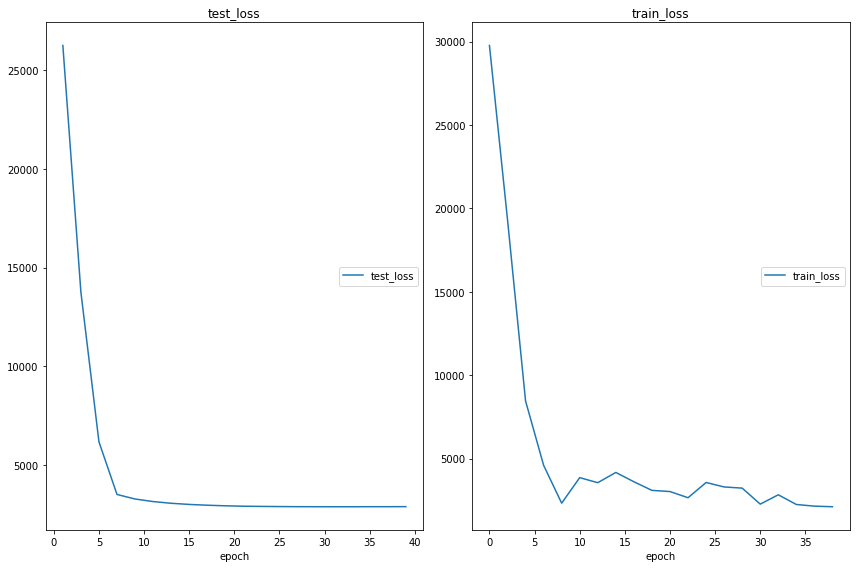

test_loss
	test_loss        	 (min: 2874.411, max: 26255.523, cur: 2879.737)
train_loss
	train_loss       	 (min: 2114.043, max: 29773.232, cur: 2114.043)


In [98]:
##
# optimiser: combines (chains) two rules: gradient clipping and ADAM
# in that order, so that ADAM is applied to the clipped gradients.
#
eta = 0.01
optimizer = optax.chain(
    optax.clip_by_global_norm(0.5),
    optax.adam(learning_rate=eta),
)
#
# initialise model params and optimiser
#
rng = jax.random.PRNGKey(seed)
# 
# we pass the first data sample of the input to infer the
# input data dimension
#
state = init(rng, next(train_dataset)[0])
#
# keep time of the training time
#
prev_time = time.time()
max_steps = 10**5
eval_every = 5000
metrics = {}
plotlosses = PlotLosses()

# Training & evaluation loop.
for step in range(max_steps):
    state, metrics = update(state, data=next(train_dataset))

    # Periodically evaluate on test set.
    if step % eval_every == 0:
        steps_per_sec = eval_every / (time.time() - prev_time)
        prev_time = time.time()
        test_loss = evaluate(state.params, next(test_dataset))
        metrics.update({"steps_per_sec": steps_per_sec})
        metrics.update({"test_loss": test_loss})
        plotlosses.update(
            {
                "train_loss": jnp.mean(metrics["train_loss"]),
            }
        )
        plotlosses.update(
            {
                "test_loss": test_loss,
            }
        )
        plotlosses.send()

Please try and get comfortable with the above code since we will be using Haiku and Optax in other practicals. If you need assistance, please call a tutor!

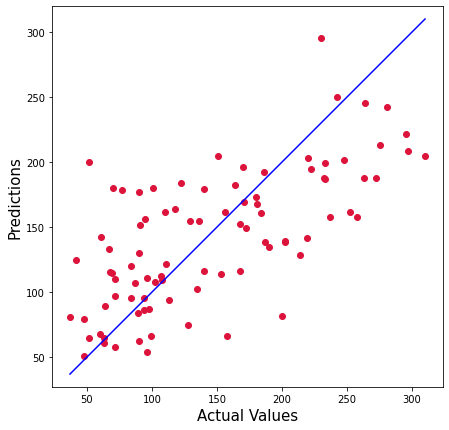

In [99]:
# @title Let's plot our predictions vs targets.

X_test, y_test = next(test_dataset)
pred = model.apply(state.params, X_test)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, pred, c="crimson")

p1 = max(max(pred), max(y_test))
p2 = min(min(pred), min(y_test))
plt.plot([p1, p2], [p1, p2], "b-")
plt.xlabel("Actual Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.axis("equal")
plt.show()

So there is some correlation with our predictions and our actual targets. This shows that we are learning a useful model for our data.

You have officially trained a model end-to-end using the latest JAX techniques! 🔥

Although, we have only done simple Linear Regression in this tutorial, you have learned optimization techniques like gradient descent, which can apply to a variety of models! 

# Summary

For other Khipu practicals, please visit [here](https://github.com/khipu-ai/practicals-2023).

# Appendix



## Derivation of partial derivatives for exercise 2.4.

Derive $\frac{\partial \mathcal{L}}{\partial w}$:
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial w} & = \frac{ \partial}{\partial w} (\frac{1}{2N} \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Definition of $\mathcal{L}$} \\
 \frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \frac{ \partial }{\partial w} ( \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Constant multiple rule} \\
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N \frac{ \partial }{\partial w} (y_i - (w x_i + b))^2 \because{Sum Rule - derivative of sum is sum of derivatives.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) \frac{ \partial }{\partial w}(y_i -(w x_i + b))  \because{Power Rule + Chain Rule.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) (-x_i)  \because{Compute derative.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1(2)}{2N} \sum_{i=1}^N  (y_i - (w x_i + b)) (-x_i)  \because{Factor constant out of summation.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  -y_ix_i + (w x_i + b)x_i  \because{Multiply brackets and simplify.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  (-y_i + (w x_i + b))x_i  \because{Rewrite.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  ((w x_i + b) -y_i )x_i  \because{Rewrite.} \\ 
\frac{\partial \mathcal{L}}{\partial w} & = \frac{1}{N} \sum_{i=1}^N  (f(x_i) -y_i )x_i  \because{Substitute in $f(x_i)$.} \\  
\end{aligned}

Derive $\frac{\partial \mathcal{L}}{\partial b}$:
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial b} & = \frac{ \partial}{\partial b} (\frac{1}{2N} \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Definition of $\mathcal{L}$} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \frac{ \partial }{\partial b} ( \sum_{i=1}^N (y_i - (w x_i + b))^2) \because{Constant multiple rule} \\
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N \frac{ \partial }{\partial b} (y_i - (w x_i + b))^2 \because{Sum Rule - derivative of sum is sum of derivatives.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) \frac{ \partial }{\partial b}(y_i -(w x_i + b))  \because{Power Rule + Chain Rule.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{2N} \sum_{i=1}^N 2 (y_i - (w x_i + b)) (-1)  \because{Compute derative.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1(2)}{2N} \sum_{i=1}^N (y_i - (w x_i + b)) (-1)  \because{Factor constant out of summation.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N (-y_i + (w x_i + b))  \because{Multiply brackets and simplify.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N ((w x_i + b) -y_i )  \because{Rewrite.} \\ 
\frac{\partial \mathcal{L}}{\partial b} & = \frac{1}{N} \sum_{i=1}^N (f(x_i) -y_i )  \because{Substitute in $f(x_i)$.} \\ 
\end{aligned}

# **Feedback**

Please provide feedback that we can use to improve our practicals in the future.

In [100]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />